## Imports

In [730]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import svd
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [349]:
pd.set_option('display.max_columns', None)

## Data Setup

### Reading file that contains data by major/field

In [468]:
data_by_major_df = pd.read_csv("Most-Recent-Field-Data-Elements.csv")

In [469]:
data_by_major_df.shape

(216638, 18)

In [470]:
columns_to_keep = ['UNITID', 'OPEID6', 'INSTNM', 'MAIN', 'CIPCODE', 'CIPDESC', 'CREDLEV','COUNT', 'MD_EARN_WNE']

In [471]:
data_by_major_df = data_by_major_df[columns_to_keep]

In [472]:
# Replacing all rows that have values suppressed for privacy reasons with np.nan
data_by_major_df = data_by_major_df.replace("PrivacySuppressed", np.nan)

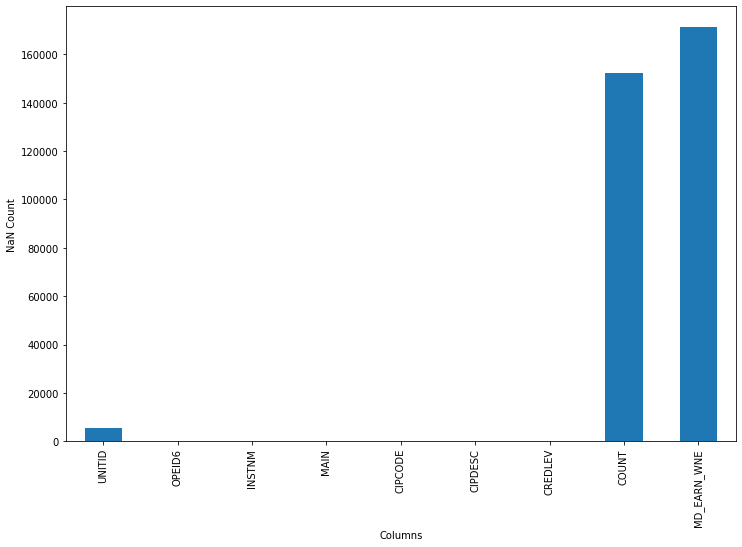

In [473]:
plt.figure(figsize=(12,8))
plt.xlabel("Columns")
plt.ylabel("NaN Count")
data_by_major_df.isna().sum().plot(kind='bar')
plt.show()

In [474]:
# Removing NaN values
data_by_major_df = data_by_major_df[~data_by_major_df["MD_EARN_WNE"].isna()]

In [475]:
data_by_major_df.shape

(45371, 9)

In [476]:
# Replacing the values in count column that are PrivacySuppressed by the median count value
data_by_major_df['COUNT'] = data_by_major_df['COUNT'].fillna(data_by_major_df['COUNT'].median())

In [477]:
# CREDLEV column mapped with what it denotes
degree_mapping = {3: 'Bachelor\x92s Degree', 5: "Master's Degree", 8: 'Graduate/Professional Certificate',\
                  7: 'First Professional Degree', 6: 'Doctoral Degree', 2: "Associate's Degree",\
                  1: 'Undergraduate Certificate or Diploma', 4: 'Post-baccalaureate Certificate'}

In [478]:
# Mapping CIPCODE and CIPDESC
major_codes = data_by_major_df[["CIPCODE", "CIPDESC"]].to_dict(orient='list')

major_mapping = {}

for i in range(len(major_codes["CIPCODE"])):
    if major_codes["CIPCODE"][i] in major_mapping:
        continue
    else:
        major_mapping[major_codes["CIPCODE"][i]] = major_codes["CIPDESC"][i]

In [479]:
# Removing rows where UNITID is not present as unable to figure out the university without UNITID
data_by_major_df = data_by_major_df[~data_by_major_df["UNITID"].isna()]

In [480]:
# Rolling up the CIPDESC and CIPCODES to higher categories so that they can they be used as features
higher_level_major_mapping = {1: "AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES", \
3: "NATURAL RESOURCES AND CONSERVATION", 4: "ARCHITECTURE AND RELATED SERVICES",\
5: "AREA, ETHNIC, CULTURAL, AND GENDER STUDIES", 9: "COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS", \
10: "COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES", 11: "COMPUTER AND INFORMATION SCIENCES AND \
SUPPORT SERVICES", 12: "PERSONAL AND CULINARY SERVICES", 13: "EDUCATION", 14: "ENGINEERING",\
15: "ENGINEERING TECHNOLOGIES/TECHNICIANS", 16: "FOREIGN LANGUAGES, LITERATURES, \
AND LINGUISTICS", 19: "FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES", 22: "LEGAL PROFESSIONS AND STUDIES", \
23: "ENGLISH LANGUAGE AND LITERATURE/LETTERS", 24: "LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",\
25: "LIBRARY SCIENCE", 26: "BIOLOGICAL AND BIOMEDICAL SCIENCES", 27: "MATHEMATICS AND STATISTICS", \
28: "RESERVE OFFICER TRAINING CORPS", 29: "MILITARY TECHNOLOGIES", 30: "MULTI/INTERDISCIPLINARY STUDIES", \
31: "PARKS, RECREATION, LEISURE, AND FITNESS STUDIES", 32: "BASIC SKILLS", 33: "CITIZENSHIP ACTIVITIES", \
34: "HEALTH-RELATED KNOWLEDGE AND SKILLS", 35: "INTERPERSONAL AND SOCIAL SKILLS", 36: "LEISURE AND RECREATIONAL \
ACTIVITIES", 37: "PERSONAL AWARENESS AND SELF-IMPROVEMENT", 38: "PHILOSOPHY AND RELIGIOUS STUDIES", \
39: "THEOLOGY AND RELIGIOUS VOCATIONS", 40: "PHYSICAL SCIENCES", 41: "SCIENCE TECHNOLOGIES/TECHNICIANS", \
42: "PSYCHOLOGY", 43: "SECURITY AND PROTECTIVE SERVICES", 44: "PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS", \
45: "SOCIAL SCIENCES", 46: "CONSTRUCTION \
TRADES", 47: "MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS", 48: "PRECISION PRODUCTION", 49: "TRANSPORTATION AND \
MATERIALS MOVING", 50: "VISUAL AND PERFORMING ARTS", 51: "HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES", \
52: "BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES", \
    53: "HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES", 54: "HISTORY", 60: "Residency Programs"}

In [481]:
def higher_level_mapping(cipcode):

    for code in higher_level_major_mapping:
        if str(cipcode).startswith(str(code)) and len(str(cipcode)) == 3 and len(str(code)) == 1:
            return higher_level_major_mapping[code]
            
        if str(cipcode).startswith(str(code)) and len(str(cipcode)) == 4 and len(str(code)) == 2:
            return higher_level_major_mapping[code]
        
    return np.nan

In [482]:
data_by_major_df["CIPDESC_NEW"] = data_by_major_df["CIPCODE"].apply(lambda x: higher_level_mapping(x))

In [483]:
data_by_major_df["CIPDESC_NEW"] = np.where(data_by_major_df["CIPDESC_NEW"].isna(), data_by_major_df["CIPDESC"], data_by_major_df["CIPDESC_NEW"])

In [484]:
# One-hot encoding of CREDLEV and CIPDESC_NEW
data_by_major_df = pd.concat([data_by_major_df, pd.get_dummies(data_by_major_df["CREDLEV"], prefix="CREDLEV_")], axis=1)

data_by_major_df = pd.concat([data_by_major_df, pd.get_dummies(data_by_major_df["CIPDESC_NEW"], prefix="CIPDESC_")], axis=1)

In [485]:
# Dropping columns that are not needed now
data_by_major_df = data_by_major_df.drop(columns="CIPDESC")
data_by_major_df = data_by_major_df.drop(columns="CIPDESC_NEW")
data_by_major_df = data_by_major_df.drop(columns="CREDLEV")
data_by_major_df = data_by_major_df.drop(columns="OPEID6")
data_by_major_df = data_by_major_df.drop(columns="MAIN")
data_by_major_df = data_by_major_df.drop(columns="INSTNM")
data_by_major_df = data_by_major_df.drop(columns="CIPCODE")

In [486]:
data_by_major_df["UNITID"] = data_by_major_df["UNITID"].astype(int) 
data_by_major_df["COUNT"] = data_by_major_df["COUNT"].astype(int) 
data_by_major_df["MD_EARN_WNE"] = data_by_major_df["MD_EARN_WNE"].astype(float) 

In [487]:
data_by_major_df.shape

(45166, 55)

In [417]:
data_by_major_df.head()

,UNITID,COUNT,MD_EARN_WNE,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS
15,100654,25,54300.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,100654,46,25400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,100654,22,54500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,100654,67,45800.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,100654,39,24000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [418]:
data_by_major_df["MD_EARN_WNE"].describe()

count     45166.000000
mean      39678.346544
std       19402.471081
min        2700.000000
25%       26300.000000
50%       35000.000000
75%       49100.000000
max      231200.000000
Name: MD_EARN_WNE, dtype: float64

### Reading file that contains data by college/university

In [508]:
data_by_institution_df = pd.read_csv("Most-Recent-Cohorts-All-Data-Elements.csv")

C:\Users\HARSH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (9,1608,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1640,1643,1648,1657,1666,1669,1674,1683,1688,1689,1690,1691,1692,1697,1700,1703,1704,1705,1706,1707,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1909,1910,1911,1912,1913,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1983,1984) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [509]:
data_by_institution_df.shape

(6806, 1987)

In [510]:
root_columns_to_keep = ["UNITID", "OPEID", "OPEID6"]

school_columns_to_keep = ["INSTNM", "MAIN", "CONTROL", "REGION", "LOCALE", \
                          "CCBASIC", "DISTANCEONLY", "CURROPER", "TUITFTE", "INEXPFTE", "OPENADMP"]
# can add more
student_columns_to_keep = ["UGDS", "DEP_INC_AVG", "IND_INC_AVG", "AGE_ENTRY",\
                           "INC_N", "UGDS_WOMEN"]
# can add more features
# removed becaue 90% missing values
# admissions_columns_to_keep = ["ADM_RATE", "SAT_AVG", "SATVR75", "SATMT75", "SATWR75", "ACTCM75"]

aid_columns_to_keep = ["PCTPELL", "PCTFLOAN"]

# earnings_columns_to_keep = ["MD_EARN_WNE_P6", "MD_EARN_WNE_P8", "MD_EARN_WNE_P10"]

In [511]:
all_columns_to_keep = []
all_columns_to_keep.extend(root_columns_to_keep)
all_columns_to_keep.extend(school_columns_to_keep)
all_columns_to_keep.extend(student_columns_to_keep)
all_columns_to_keep.extend(aid_columns_to_keep)

In [512]:
data_by_institution_df_new = data_by_institution_df[all_columns_to_keep]

In [513]:
data_by_institution_df_new = data_by_institution_df_new.replace("PrivacySuppressed", np.nan)

In [514]:
data_by_institution_df_new["OPENADMP"] = data_by_institution_df_new["OPENADMP"].fillna(0)

In [515]:
# one-hot encoding several college features
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["MAIN"]\
                                                                                   , prefix="MAIN_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["CONTROL"]\
                                                                                   , prefix="CONTROL_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["REGION"]\
                                                                                   , prefix="REGION_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["LOCALE"]\
                                                                                   , prefix="LOCALE_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["CCBASIC"]\
                                                                                   , prefix="CCBASIC_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, \
                        pd.get_dummies(data_by_institution_df_new["DISTANCEONLY"], prefix="DISTANCEONLY_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, \
                        pd.get_dummies(data_by_institution_df_new["CURROPER"], prefix="CURROPER_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, \
                        pd.get_dummies(data_by_institution_df_new["OPENADMP"], prefix="OPENADMP_")], axis=1)

In [516]:
data_by_institution_df_new = data_by_institution_df_new.drop(columns="MAIN")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="CONTROL")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="REGION")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="LOCALE")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="CCBASIC")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="DISTANCEONLY")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="CURROPER")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="OPENADMP")

In [517]:
data_by_institution_df_new.head()

,UNITID,OPEID,OPEID6,INSTNM,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,100654,100200,1002,Alabama A & M University,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.28374137,3186,0.5924,0.7067,0.7503,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,100663,105200,1052,University of Alabama at Birmingham,13177.0,16454.0,13186.0,61110.80038,30607.18029,23.60797466,5367,0.6070,0.3632,0.5127,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,100690,2503400,25034,Amridge University,14273.0,4206.0,351.0,25211.03226,20596.15849,33.6722973,296,0.6809,0.7673,0.8962,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,100706,105500,1055,University of Alabama in Huntsville,8677.0,9242.0,7458.0,72240.89262,27941.82196,22.72791963,2389,0.4204,0.2698,0.4192,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,100724,100500,1005,Alabama State University,10160.0,8527.0,3903.0,34468.57181,8551.802974,20.13099042,2504,0.6290,0.7448,0.7845,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [518]:
data_by_institution_df_new.shape

(6806, 83)

### Merging the 2 dataframes

In [519]:
merged_df = pd.merge(data_by_major_df, data_by_institution_df_new, on="UNITID", how="left")

In [520]:
# Removing nan values
merged_df = merged_df.replace("PrivacySuppressed", np.nan)

In [521]:
# Removing rows that have more than 50% nan values
merged_df = merged_df[merged_df.isna().mean(axis=1) < 0.5]

In [522]:
merged_df = merged_df[~merged_df["PCTPELL"].isna()]

In [523]:
merged_df = merged_df[~merged_df["DEP_INC_AVG"].isna()]

In [524]:
merged_df = merged_df[~merged_df["UGDS_WOMEN"].isna()]

In [525]:
merged_df = merged_df[~merged_df["TUITFTE"].isna()]

In [526]:
merged_df["DEP_INC_AVG"] = merged_df["DEP_INC_AVG"].astype(float) 
merged_df["IND_INC_AVG"] = merged_df["IND_INC_AVG"].astype(float) 
merged_df["AGE_ENTRY"] = merged_df["AGE_ENTRY"].astype(float) 
merged_df["INC_N"] = merged_df["INC_N"].astype(float)

In [527]:
# Mapping college UNITID and its name
college_unit_id = merged_df[["UNITID", "INSTNM"]].to_dict(orient='list')

college_mapping = {}

for i in range(len(college_unit_id["UNITID"])):
    if college_unit_id["UNITID"][i] in college_mapping:
        continue
    else:
        college_mapping[college_unit_id["UNITID"][i]] = college_unit_id["INSTNM"][i]

In [528]:
merged_df = merged_df.drop(columns="UNITID")
merged_df = merged_df.drop(columns="OPEID")
merged_df = merged_df.drop(columns="OPEID6")
merged_df = merged_df.drop(columns="INSTNM")

In [529]:
merged_df.shape

(40504, 133)

In [530]:
merged_df.head()

,COUNT,MD_EARN_WNE,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,25,54300.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.283741,3186.0,0.5924,0.7067,0.7503,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,46,25400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.283741,3186.0,0.5924,0.7067,0.7503,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,22,54500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

## Performing PCA

In [531]:
X = merged_df.copy()

# Defining a Standard Scaler object
scaler=StandardScaler()

#Fitting the data to compute the mean and variance for each feature on the training set
scaler.fit(X)

## Fitting
scaled_X = scaler.transform(X)

In [532]:
## Defining a PCA object
pca = PCA(n_components=scaled_X.shape[1])
principalComponents = pca.fit(scaled_X)

<Figure size 432x288 with 0 Axes>

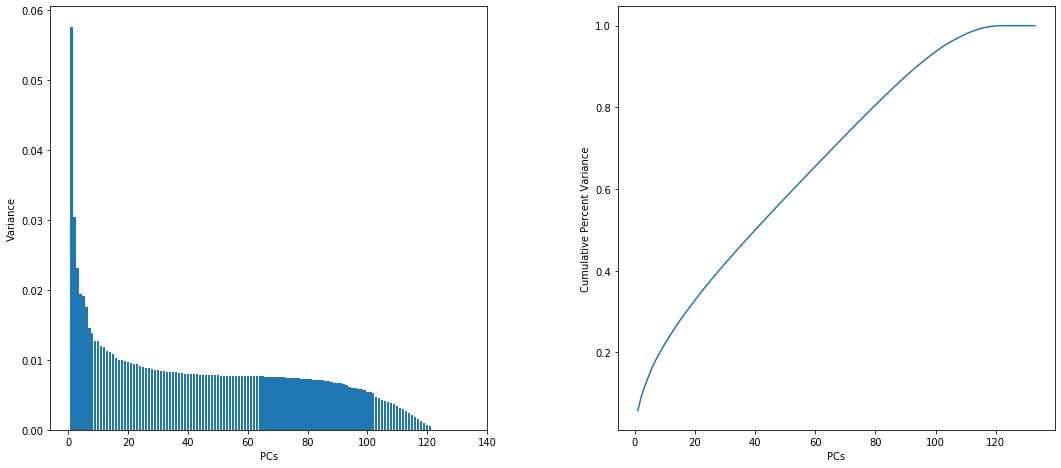

In [533]:
## Variance
pcs_var = principalComponents.explained_variance_ratio_
cum_var = np.cumsum(pcs_var)
pcs = range(1, scaled_X.shape[1]+1)

fig = plt.figure()
plt.figure(figsize=(18,6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.3)

## PCs vs Variance plot
plt.subplot(1, 2, 1)
plt.xlabel('PCs')
plt.ylabel('Variance')
plt.bar(pcs, pcs_var)

## Scree Plot
plt.subplot(1, 2, 2)
plt.xlabel('PCs')
plt.ylabel('Cumulative Percent Variance')
plt.plot(pcs, cum_var)
plt.show()

First, I wanted to see if the features that have been included are able to predict the range of the income level. So, I chose the median income as the income that would form the class for logistic regression. Income below the median level would be classified as 0 and above it would be classified as 1. 
I also performed multinomial logistic regression, dividing the income into 3 classes.

## Logistic Regression

In [600]:
merged_df_logistic = merged_df.copy()

In [601]:
merged_df_logistic.head()

,COUNT,MD_EARN_WNE,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,25,54300.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.283741,3186.0,0.5924,0.7067,0.7503,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,46,25400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.283741,3186.0,0.5924,0.7067,0.7503,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,22,54500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [602]:
merged_df_logistic["MD_EARN_WNE"].describe()

count     40504.000000
mean      40470.620186
std       19413.121813
min        2700.000000
25%       27200.000000
50%       35900.000000
75%       50000.000000
max      231200.000000
Name: MD_EARN_WNE, dtype: float64

In [603]:
merged_df_logistic["Income Greater than Median"] = np.where(merged_df_logistic["MD_EARN_WNE"] >= \
                                                            merged_df_logistic["MD_EARN_WNE"].median(), 1, 0)

In [604]:
merged_df_logistic = merged_df_logistic.drop(columns="MD_EARN_WNE")

In [605]:
def standardize(column):
    column = ((column - np.mean(column))/np.std(column))
    return column

In [606]:
merged_df_logistic["TUITFTE"] = standardize(merged_df_logistic["TUITFTE"])
merged_df_logistic["INEXPFTE"] = standardize(merged_df_logistic["INEXPFTE"])
merged_df_logistic["UGDS"] = standardize(merged_df_logistic["UGDS"])
merged_df_logistic["DEP_INC_AVG"] = standardize(merged_df_logistic["DEP_INC_AVG"])
merged_df_logistic["IND_INC_AVG"] = standardize(merged_df_logistic["IND_INC_AVG"])
merged_df_logistic["AGE_ENTRY"] = standardize(merged_df_logistic["AGE_ENTRY"])
merged_df_logistic["INC_N"] = standardize(merged_df_logistic["INC_N"])
merged_df_logistic["COUNT"] = standardize(merged_df_logistic["COUNT"])
merged_df_logistic["UGDS_WOMEN"] = standardize(merged_df_logistic["UGDS_WOMEN"])
merged_df_logistic["PCTPELL"] = standardize(merged_df_logistic["PCTPELL"])
merged_df_logistic["PCTFLOAN"] = standardize(merged_df_logistic["PCTFLOAN"])

In [607]:
merged_df_logistic.head()

,COUNT,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0,Income Greater than Median
0,-0.289642,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,-0.241172,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1

In [608]:
Y_log = merged_df_logistic[["Income Greater than Median"]]
X_log = merged_df_logistic.drop(columns="Income Greater than Median")

In [609]:
X_train = X_log[:int(0.7*X_log.shape[0])] 
X_test = X_log[int(0.7*X_log.shape[0]):]

Y_train = Y_log[:int(0.7*Y_log.shape[0])]
Y_test = Y_log[int(0.7*Y_log.shape[0]):]

In [610]:
X_train.shape, X_test.shape

((28352, 132), (12152, 132))

In [611]:
Y_train.shape, Y_test.shape

((28352, 1), (12152, 1))

In [612]:
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, Y_train)
y_pred = cls.predict(X_test)

C:\Users\HARSH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HARSH\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [613]:
print(accuracy_score(Y_test, y_pred))

0.8366524028966426


In [614]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(Y_test["Income Greater than Median"], model_pred)
    
    # Return the performance metric
    return model_mae

In [623]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()

In [628]:
def plot_imp_features(feature_imp):
    plt.figure(figsize=(15,10))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()

feature_imp_positive = pd.Series(coefs, index=list(X_train.columns)).sort_values(ascending=False)[:20]
feature_imp_negative = pd.Series(coefs, index=list(X_train.columns)).sort_values()[:20]

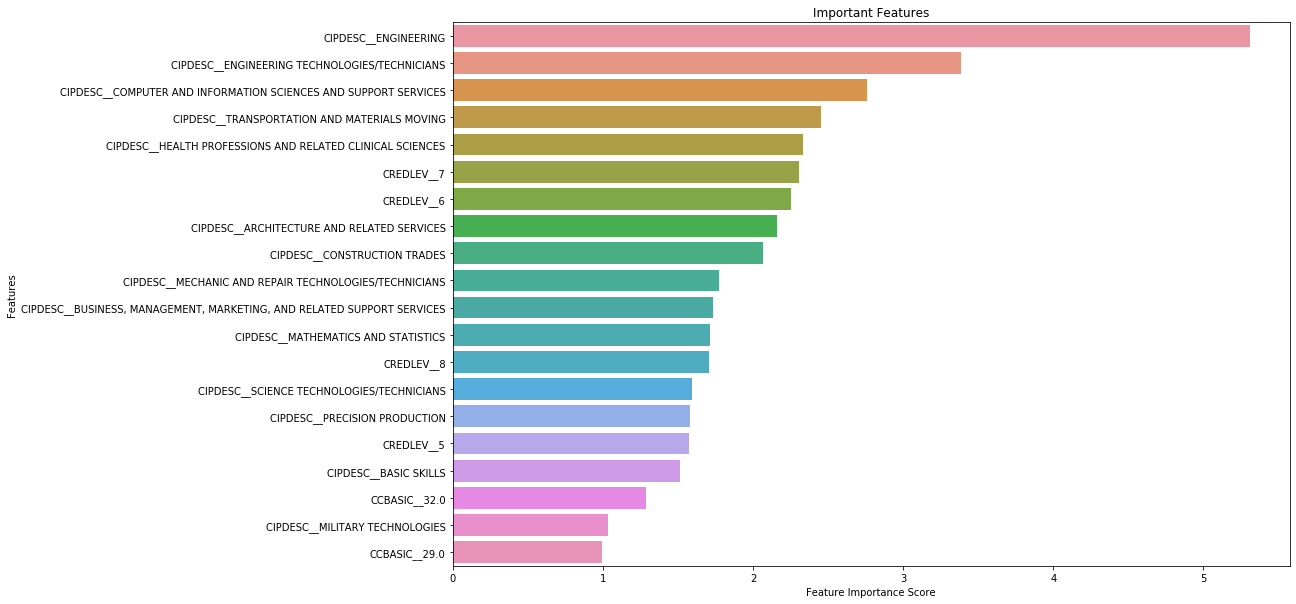

In [629]:
plot_imp_features(feature_imp_positive)

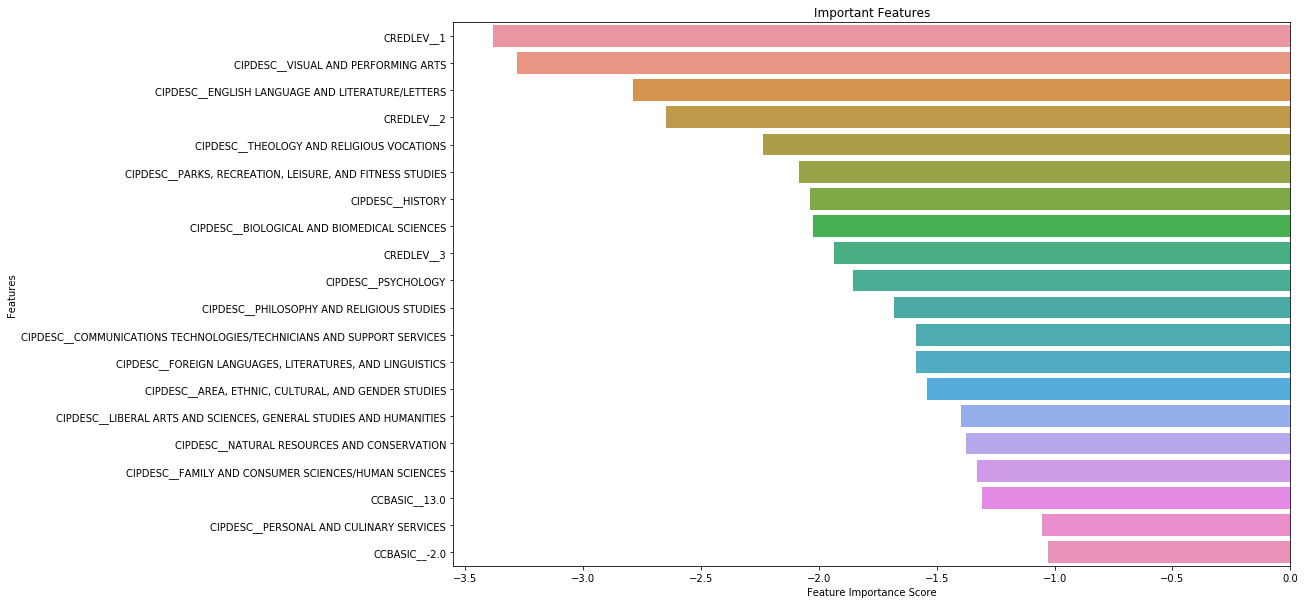

In [630]:
plot_imp_features(feature_imp_negative)

## Multinomial Logistic Regression

In [680]:
merged_df_multi_logistic = merged_df.copy()

In [681]:
merged_df_multi_logistic["MD_EARN_WNE"].describe()

count     40504.000000
mean      40470.620186
std       19413.121813
min        2700.000000
25%       27200.000000
50%       35900.000000
75%       50000.000000
max      231200.000000
Name: MD_EARN_WNE, dtype: float64

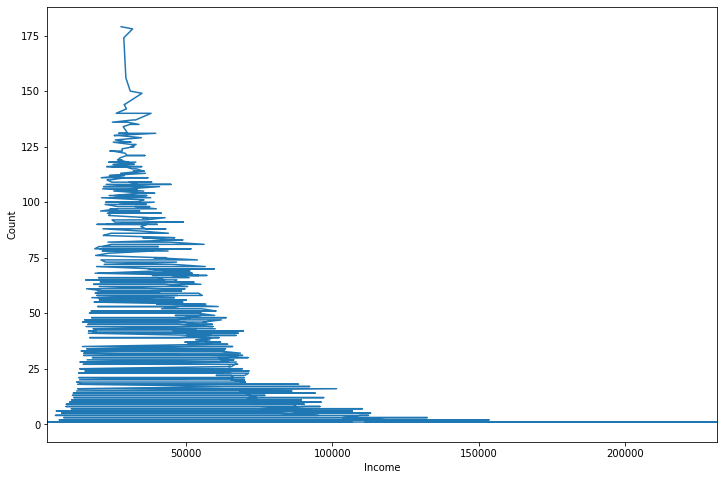

In [682]:
plt.figure(figsize=(12,8))
merged_df_multi_logistic["MD_EARN_WNE"].value_counts().plot(kind='line')
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

In [683]:
# merged_df_multi_logistic["Income Class"] = np.where(merged_df_multi_logistic["MD_EARN_WNE"] < 20000, 0, \
# np.where((merged_df_multi_logistic["MD_EARN_WNE"] >= 20000) & (merged_df_multi_logistic["MD_EARN_WNE"] < 40000), 1, \
# np.where((merged_df_multi_logistic["MD_EARN_WNE"] >= 40000) & (merged_df_multi_logistic["MD_EARN_WNE"] < 60000), 2, 3)))

In [684]:
merged_df_multi_logistic["Income Class"] = np.where(merged_df_multi_logistic["MD_EARN_WNE"] < 30000, 0, \
np.where((merged_df_multi_logistic["MD_EARN_WNE"] >= 30000) & (merged_df_multi_logistic["MD_EARN_WNE"] < 60000), 1, 2))

In [685]:
merged_df_multi_logistic = merged_df_multi_logistic.drop(columns="MD_EARN_WNE")

In [686]:
merged_df_multi_logistic.head()

,COUNT,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0,Income Class
0,25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.283741,3186.0,0.5924,0.7067,0.7503,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,46,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7413.0,5384.0,4990.0,34779.08568,10340.34603,20.283741,3186.0,0.5924,0.7067,0.7503,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [687]:
def standardize(column):
    column = ((column - np.mean(column))/np.std(column))
    return column

In [688]:
merged_df_multi_logistic["TUITFTE"] = standardize(merged_df_multi_logistic["TUITFTE"])
merged_df_multi_logistic["INEXPFTE"] = standardize(merged_df_multi_logistic["INEXPFTE"])
merged_df_multi_logistic["UGDS"] = standardize(merged_df_multi_logistic["UGDS"])
merged_df_multi_logistic["DEP_INC_AVG"] = standardize(merged_df_multi_logistic["DEP_INC_AVG"])
merged_df_multi_logistic["IND_INC_AVG"] = standardize(merged_df_multi_logistic["IND_INC_AVG"])
merged_df_multi_logistic["AGE_ENTRY"] = standardize(merged_df_multi_logistic["AGE_ENTRY"])
merged_df_multi_logistic["INC_N"] = standardize(merged_df_multi_logistic["INC_N"])
merged_df_multi_logistic["COUNT"] = standardize(merged_df_multi_logistic["COUNT"])
merged_df_multi_logistic["UGDS_WOMEN"] = standardize(merged_df_multi_logistic["UGDS_WOMEN"])
merged_df_multi_logistic["PCTPELL"] = standardize(merged_df_multi_logistic["PCTPELL"])
merged_df_multi_logistic["PCTFLOAN"] = standardize(merged_df_multi_logistic["PCTFLOAN"])

In [689]:
Y_multi_log = merged_df_multi_logistic[["Income Class"]]
X_multi_log = merged_df_multi_logistic.drop(columns="Income Class")

In [690]:
X_train = X_multi_log[:int(0.7*X_multi_log.shape[0])] 
X_test = X_multi_log[int(0.7*X_multi_log.shape[0]):]

Y_train = Y_multi_log[:int(0.7*Y_multi_log.shape[0])]
Y_test = Y_multi_log[int(0.7*Y_multi_log.shape[0]):]

In [691]:
X_train.shape, Y_train.shape

((28352, 132), (28352, 1))

In [692]:
X_test.shape, Y_test.shape

((12152, 132), (12152, 1))

In [693]:
X_train.head()

,COUNT,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,-0.289642,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.241172,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.296566,0,0,1,0,0,0,0,

In [694]:
Y_train.head()

,Income Class
0,1
1,0
2,1
3,1
4,0


In [695]:
# logistic regression
cls_multi = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)

# cls.fit(X_train, Y_train)
y_pred = cls_multi.predict(X_test)

C:\Users\HARSH\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [696]:
print(accuracy_score(Y_test, y_pred))

0.7327188940092166


In [697]:
print(fit_and_evaluate(cls_multi))

C:\Users\HARSH\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2714779460171165


In [698]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()

In [699]:
def plot_imp_features(feature_imp):
    plt.figure(figsize=(15,10))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()

feature_imp_positive = pd.Series(coefs, index=list(X_train.columns)).sort_values(ascending=False)[:20]
feature_imp_negative = pd.Series(coefs, index=list(X_train.columns)).sort_values()[:20]

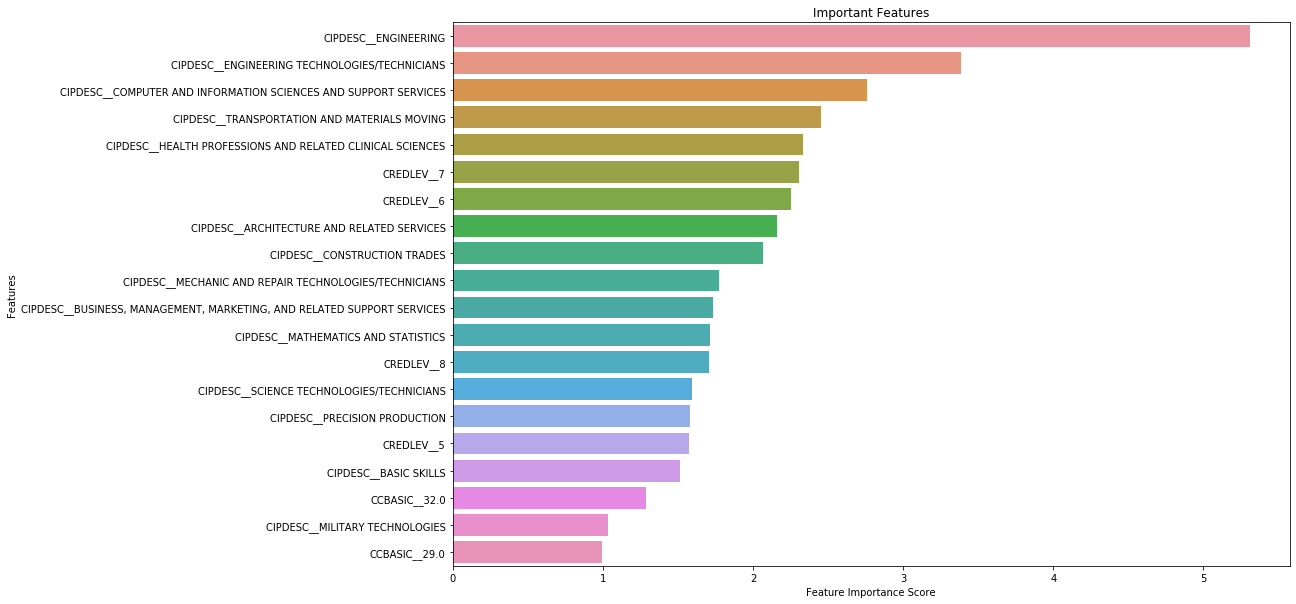

In [700]:
plot_imp_features(feature_imp_positive)

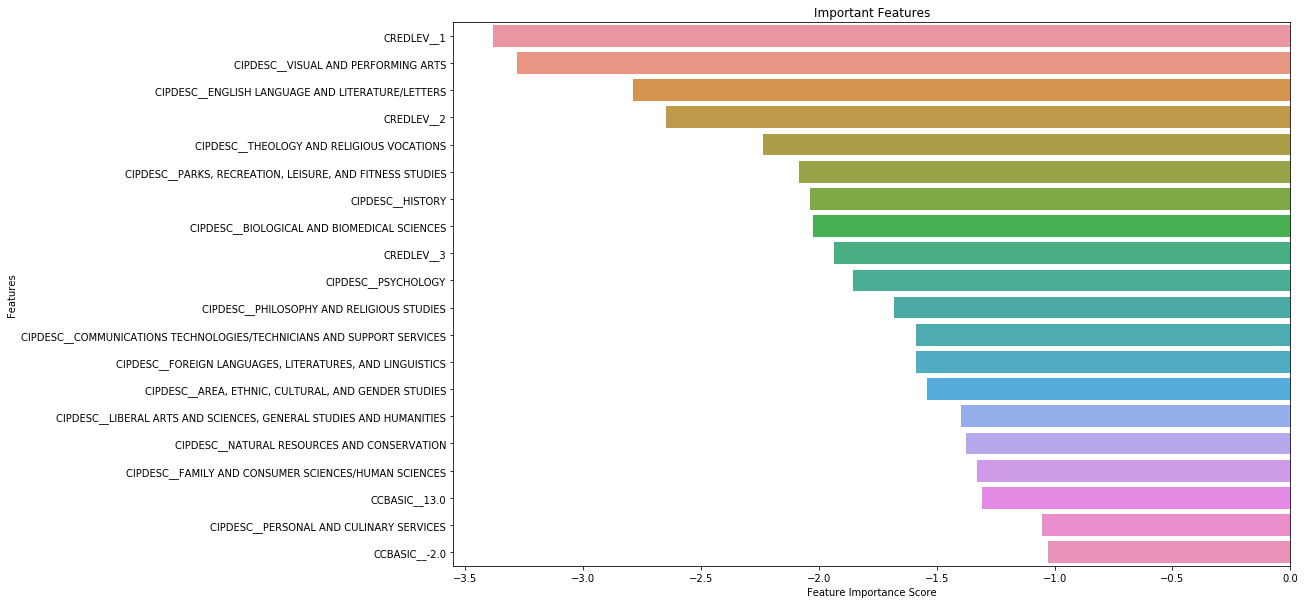

In [701]:
plot_imp_features(feature_imp_negative)

Then I moved towards actual student income prediction, now that I had a sense of wat features were more important in determining the student income. I performed simple linear regression, sparse regression and then decision tree as well as random forest regression. Sparse regression (LASSO) gave me the best results for the student income with a RMSE of approximately 12000. 

## Linear Regression

In [706]:
merged_df_linear = merged_df.copy()

In [707]:
def standardize(column):
    column = ((column - np.mean(column))/np.std(column))
    return column

In [708]:
merged_df_linear["TUITFTE"] = standardize(merged_df_linear["TUITFTE"])
merged_df_linear["INEXPFTE"] = standardize(merged_df_linear["INEXPFTE"])
merged_df_linear["UGDS"] = standardize(merged_df_linear["UGDS"])
merged_df_linear["DEP_INC_AVG"] = standardize(merged_df_linear["DEP_INC_AVG"])
merged_df_linear["IND_INC_AVG"] = standardize(merged_df_linear["IND_INC_AVG"])
merged_df_linear["AGE_ENTRY"] = standardize(merged_df_linear["AGE_ENTRY"])
merged_df_linear["INC_N"] = standardize(merged_df_linear["INC_N"])
merged_df_linear["COUNT"] = standardize(merged_df_linear["COUNT"])
merged_df_linear["UGDS_WOMEN"] = standardize(merged_df_linear["UGDS_WOMEN"])
merged_df_linear["PCTPELL"] = standardize(merged_df_linear["PCTPELL"])
merged_df_linear["PCTFLOAN"] = standardize(merged_df_linear["PCTFLOAN"])

In [709]:
merged_df_linear.head()

,COUNT,MD_EARN_WNE,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,-0.289642,54300.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.241172,25400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.

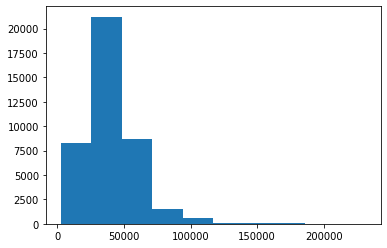

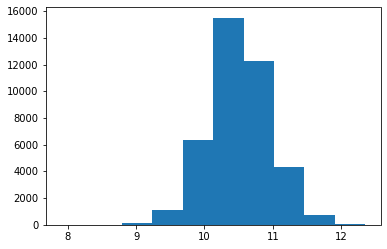

In [710]:
# To check the distribution of median income 
plt.hist(merged_df_linear["MD_EARN_WNE"].values)
plt.show()
plt.hist(np.log(merged_df_linear["MD_EARN_WNE"].values))
plt.show()

In [711]:
Y_linear = merged_df_linear[["MD_EARN_WNE"]]
# Y_linear["MD_EARN_WNE"] = np.log(merged_df_linear["MD_EARN_WNE"])
X_linear = merged_df_linear.drop(columns="MD_EARN_WNE")

In [712]:
X_train = X_linear[:int(0.8*X_linear.shape[0])] 
X_test = X_linear[int(0.8*X_linear.shape[0]):]

Y_train = Y_linear[:int(0.8*Y_linear.shape[0])]
Y_test = Y_linear[int(0.8*Y_linear.shape[0]):]

In [713]:
regressor = LinearRegression()  
regressor.fit(X_train, Y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [714]:
y_pred = regressor.predict(X_test)

In [715]:
df = pd.DataFrame({'Actual': Y_test["MD_EARN_WNE"], 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
33984,25100.0,33295.875
33985,34300.0,27149.375
33986,39700.0,43698.875
33987,29100.0,28281.125
33988,33400.0,27738.375


In [716]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 4510287271128.653
Mean Squared Error: 3.602487105137682e+26
Root Mean Squared Error: 18980218926918.84


## Sparse Regression (LASSO)

In [726]:
def linear_regression_lasso(output_df, alpha):
    lasso = Lasso(alpha=alpha)  
    lasso.fit(X_train, Y_train) 
    predicted = lasso.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(Y_test, predicted))
    # Creating the output dataframe
    output_df.loc[alpha, 'rmse'] = rmse
    return output_df

In [ ]:
lasso_alpha_df = pd.DataFrame()

alphas = np.linspace(0,1,100)
for a in alphas:
    lasso_alpha_df = linear_regression_lasso(lasso_alpha_df, a)

lasso_alpha_df.insert(0, column = "alpha", value=alphas)

In [734]:
lasso_alpha_df.head()

,alpha,rmse
0.000000,0.000000,12038.860565
0.010101,0.010101,12042.904315
0.020202,0.020202,12046.014508
0.030303,0.030303,12049.150983
0.040404,0.040404,12051.885853


In [736]:
lasso_alpha_df[lasso_alpha_df["rmse"] == lasso_alpha_df["rmse"].min()]

,alpha,rmse
1.0,1.0,12005.670311


In [737]:
lasso = Lasso(alpha=1)  
lasso.fit(X_train, Y_train) 

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [738]:
y_pred_l = lasso.predict(X_test)

In [739]:
df = pd.DataFrame({'Actual': Y_test["MD_EARN_WNE"], 'Predicted': y_pred_l.flatten()})
df.head()

,Actual,Predicted
33984,25100.0,33302.871096
33985,34300.0,27186.230108
33986,39700.0,43733.449065
33987,29100.0,28326.784072
33988,33400.0,27772.354312


In [740]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_l))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_l))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_l)))

Mean Absolute Error: 8880.705385563904
Mean Squared Error: 144136119.60844946
Root Mean Squared Error: 12005.670310667767


## Decision Tree Regressor

In [741]:
merged_df_decision_tree = merged_df.copy()

In [707]:
def standardize(column):
    column = ((column - np.mean(column))/np.std(column))
    return column

In [742]:
merged_df_decision_tree["TUITFTE"] = standardize(merged_df_decision_tree["TUITFTE"])
merged_df_decision_tree["INEXPFTE"] = standardize(merged_df_decision_tree["INEXPFTE"])
merged_df_decision_tree["UGDS"] = standardize(merged_df_decision_tree["UGDS"])
merged_df_decision_tree["DEP_INC_AVG"] = standardize(merged_df_decision_tree["DEP_INC_AVG"])
merged_df_decision_tree["IND_INC_AVG"] = standardize(merged_df_decision_tree["IND_INC_AVG"])
merged_df_decision_tree["AGE_ENTRY"] = standardize(merged_df_decision_tree["AGE_ENTRY"])
merged_df_decision_tree["INC_N"] = standardize(merged_df_decision_tree["INC_N"])
merged_df_decision_tree["COUNT"] = standardize(merged_df_decision_tree["COUNT"])
merged_df_decision_tree["UGDS_WOMEN"] = standardize(merged_df_decision_tree["UGDS_WOMEN"])
merged_df_decision_tree["PCTPELL"] = standardize(merged_df_decision_tree["PCTPELL"])
merged_df_decision_tree["PCTFLOAN"] = standardize(merged_df_decision_tree["PCTFLOAN"])

In [743]:
merged_df_decision_tree.head()

,COUNT,MD_EARN_WNE,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES/TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PERSONAL AWARENESS AND SELF-IMPROVEMENT,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,-0.289642,54300.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.241172,25400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.332935,-0.485415,-0.429367,-1.119173,-1.727395,-1.020872,-0.398582,0.011009,1.714589,1.302561,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.

In [744]:
Y_dt = merged_df_decision_tree[["MD_EARN_WNE"]]
# Y_linear["MD_EARN_WNE"] = np.log(merged_df_linear["MD_EARN_WNE"])
X_dt = merged_df_decision_tree.drop(columns="MD_EARN_WNE")

In [746]:
X_train = X_dt[:int(0.7*X_dt.shape[0])] 
X_test = X_dt[int(0.7*X_dt.shape[0]):]

Y_train = Y_dt[:int(0.7*Y_dt.shape[0])]
Y_test = Y_dt[int(0.7*Y_dt.shape[0]):]

In [747]:
X_train.shape, X_test.shape

((28352, 132), (12152, 132))

In [748]:
Y_train.shape, Y_test.shape

((28352, 1), (12152, 1))

In [749]:
model_dt = DecisionTreeRegressor(max_depth=4,min_samples_leaf=3)

model_dt.fit(X_train,Y_train)
model_dt.predict(X_test)


array([33609.58680681, 47952.04620462, 47952.04620462, ...,
       65101.56739812, 30004.23280423, 33609.58680681])

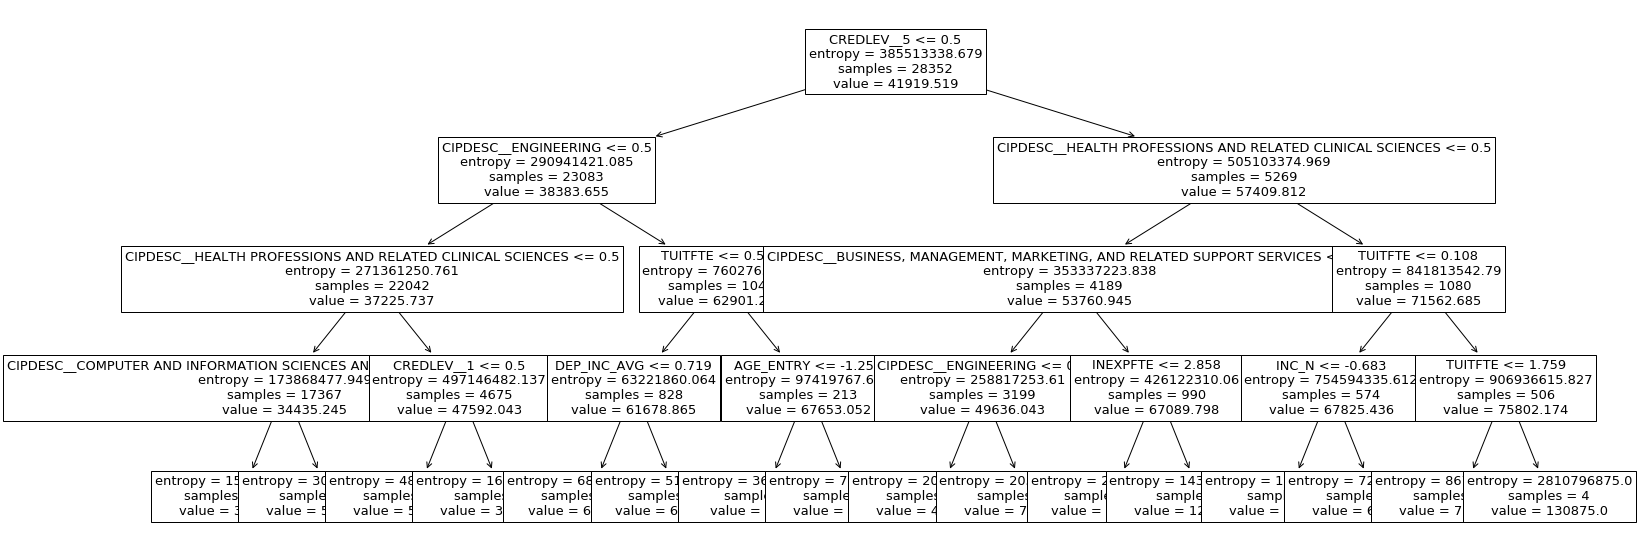

In [751]:
plt.figure(figsize=(25,10))
plot_tree(model_dt,feature_names=list(X_train), fontsize=13)
plt.show()

244327597.79074353

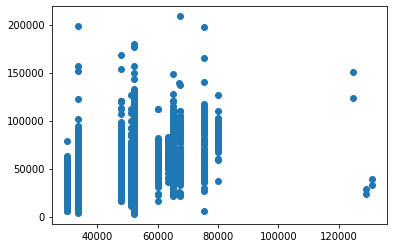

In [752]:
# Accuracy of this decision tree
prediction_dt = model_dt.predict(X_test)
plt.scatter(prediction_dt, Y_test)

In [763]:
print("RMSE for Decision Tree: {}".format(np.sqrt(np.mean(((Y_test["MD_EARN_WNE"]-prediction_dt))**2))))

RMSE for Decision Tree: 15630.98198421147


In [756]:
def plot_imp_features(feature_imp):
    plt.figure(figsize=(15,10))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()

In [757]:
feature_imp = pd.Series(model_dt.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)[:9]

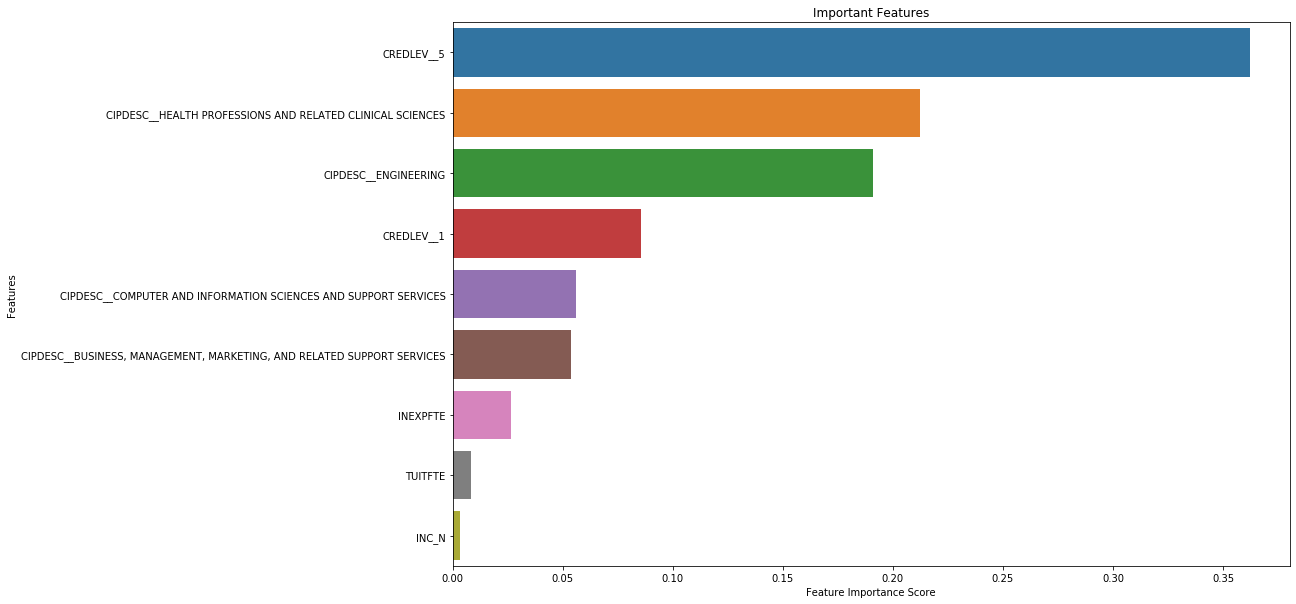

In [758]:
plot_imp_features(feature_imp)

In [765]:
model = RandomForestRegressor(n_estimators=1000,max_features=10,max_depth=4)
model.fit(X_train,Y_train)
prediction_RT=model.predict(X_test)

In [766]:
print("RMSE for Random Forest: {}".format(np.sqrt(np.mean(((Y_test["MD_EARN_WNE"]-prediction_RT))**2))))

RMSE for Random Forest: 15260.255590361283


After running all these models, I observed that to be more accurate about student income predictions, we will need student-related features like age, gender, past experiences, skills etc. That will be useful in generating more accurate predictions. 
To find this data, we can use sites like Blind but even LinkedIn APIs will be quite useful in this case. If we aer able to get access to accurate student data by scraping other websites, that also might work. 
Or we can scrape resumes and figure out the information through that. A lot of pointers for scraping resumes might be available.

Once we have student information, we can train our models on student + major + university information and observe the results. I also feel that we can train a neural network model on this data to be more accurate than sparse regression about student incomes. I feel there is enough data for a neural network to run its computatations.